In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import show_images
from functions import match_descriptors, get_good_matches, ransac_homography, compute_homography, warp_images

In [18]:
cuadro0 = cv2.imread('img/cuadro_0.jpg', cv2.IMREAD_GRAYSCALE) # --> source image 
cuadro1 = cv2.imread('img/cuadro_1.jpg', cv2.IMREAD_GRAYSCALE)  # --> destination image 1  
cuadro2 = cv2.imread('img/cuadro_2.jpg', cv2.IMREAD_GRAYSCALE) # --> destination image  2

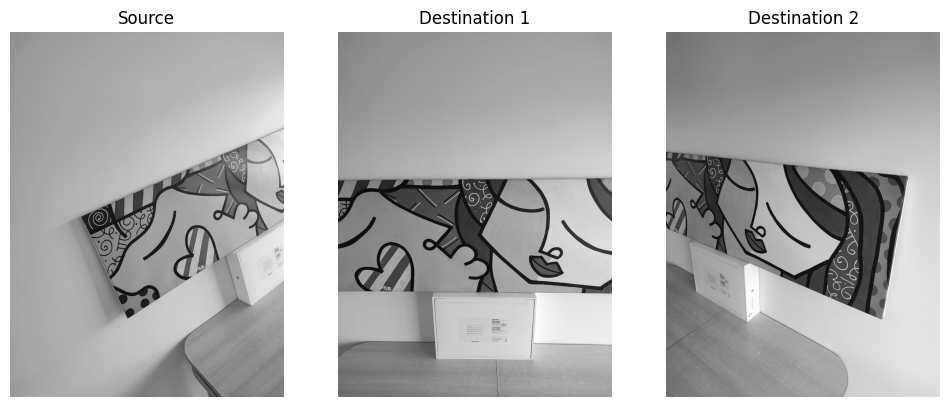

In [19]:
# Display images
show_images([
    cuadro0, cuadro1, cuadro2
], ["Source", "Destination 1", "Destination 2"])

In [20]:
# Check image sizes
print('Source Image Size:', cuadro0.shape)
print('Destination Image 1 Size:', cuadro1.shape)
print('Destination Image 2 Size:', cuadro2.shape)

Source Image Size: (4096, 3072)
Destination Image 1 Size: (4096, 3072)
Destination Image 2 Size: (4096, 3072)


In [21]:
# Busqueda de keypoints y descriptores
algo = cv2.SIFT_create()
kp0, des0 = algo.detectAndCompute(cuadro0, None)
kp1, des1 = algo.detectAndCompute(cuadro1, None)
kp2, des2 = algo.detectAndCompute(cuadro2, None)

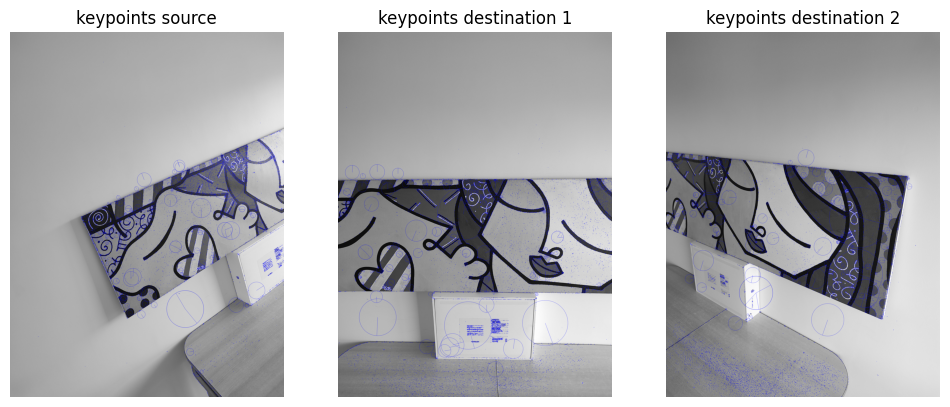

In [22]:
kp_cuadro0 = cv2.cvtColor(cuadro0, cv2.COLOR_GRAY2BGR)
kp_cuadro1 = cv2.cvtColor(cuadro1, cv2.COLOR_GRAY2BGR)
kp_cuadro2 = cv2.cvtColor(cuadro2, cv2.COLOR_GRAY2BGR)

# Display keypoints
kp_cuadro0 = cv2.drawKeypoints(cuadro0, kp0, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_cuadro1 = cv2.drawKeypoints(cuadro1, kp1, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_cuadro2 = cv2.drawKeypoints(cuadro2, kp2, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images
show_images([
    kp_cuadro0, kp_cuadro1, kp_cuadro2
], ["keypoints source", "keypoints destination 1", "keypoints destination 2"])

In [24]:
matches01, matchesMask01 = match_descriptors(des0, des1)
matches12, matchesMask12 = match_descriptors(des1, des2)

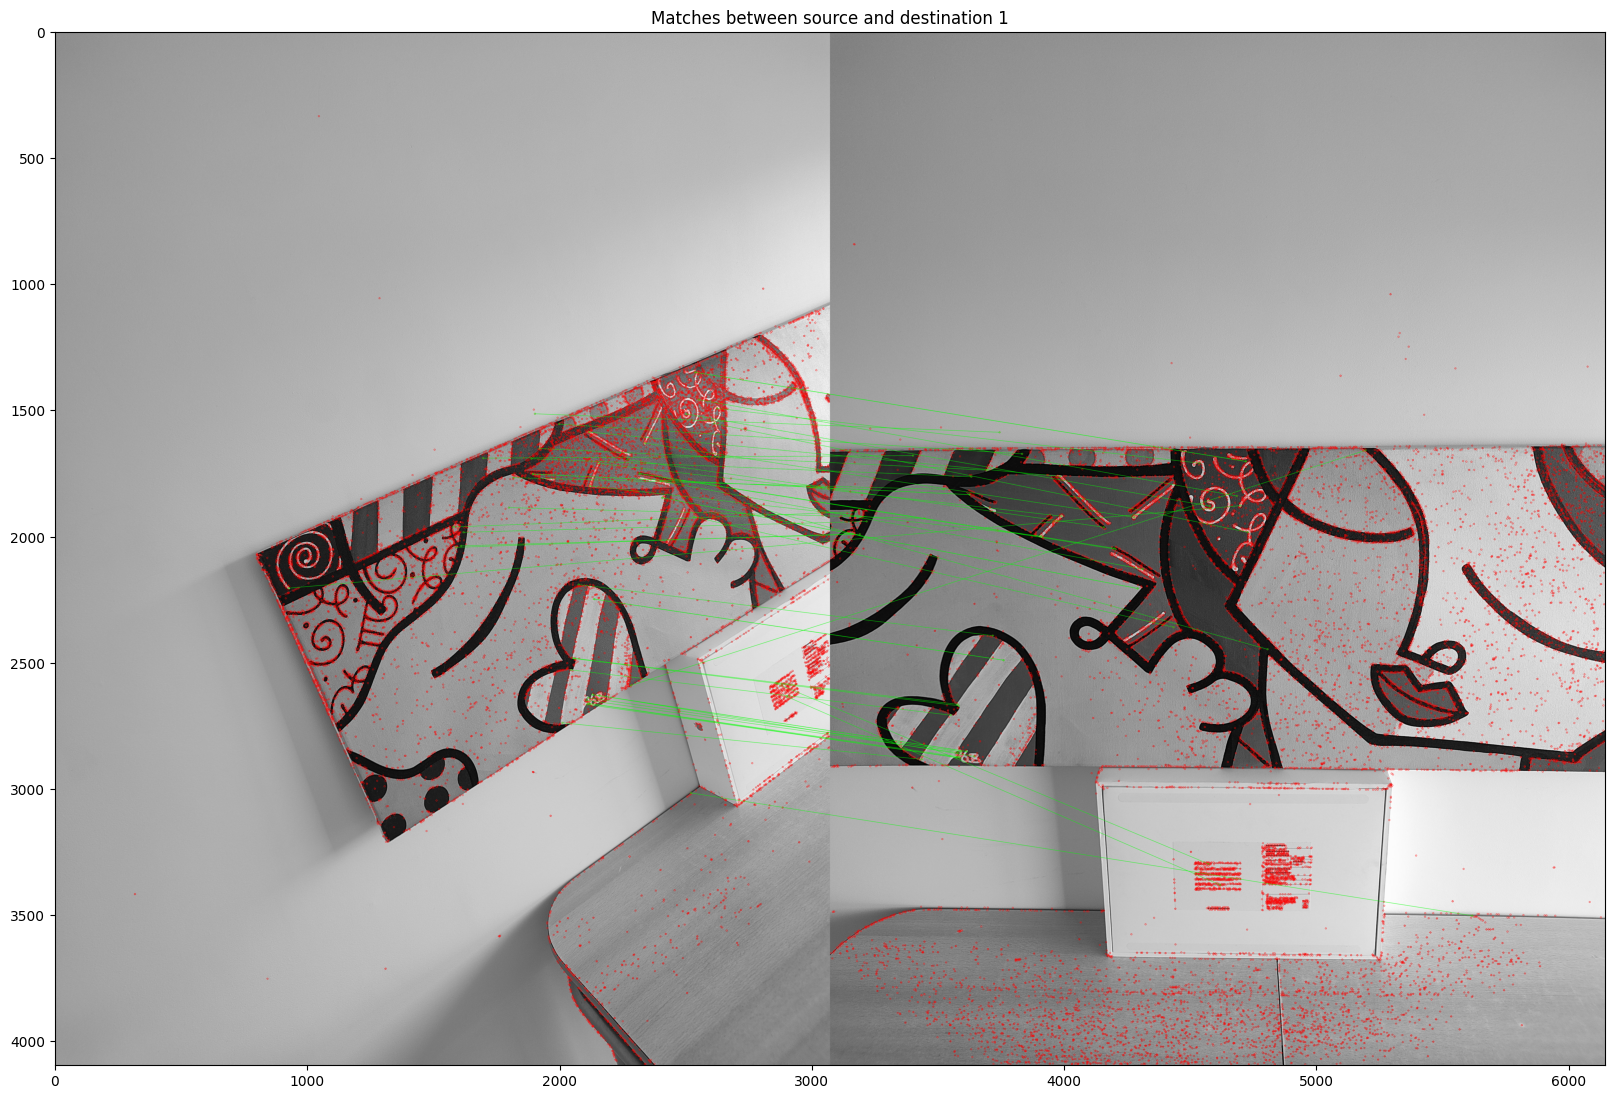

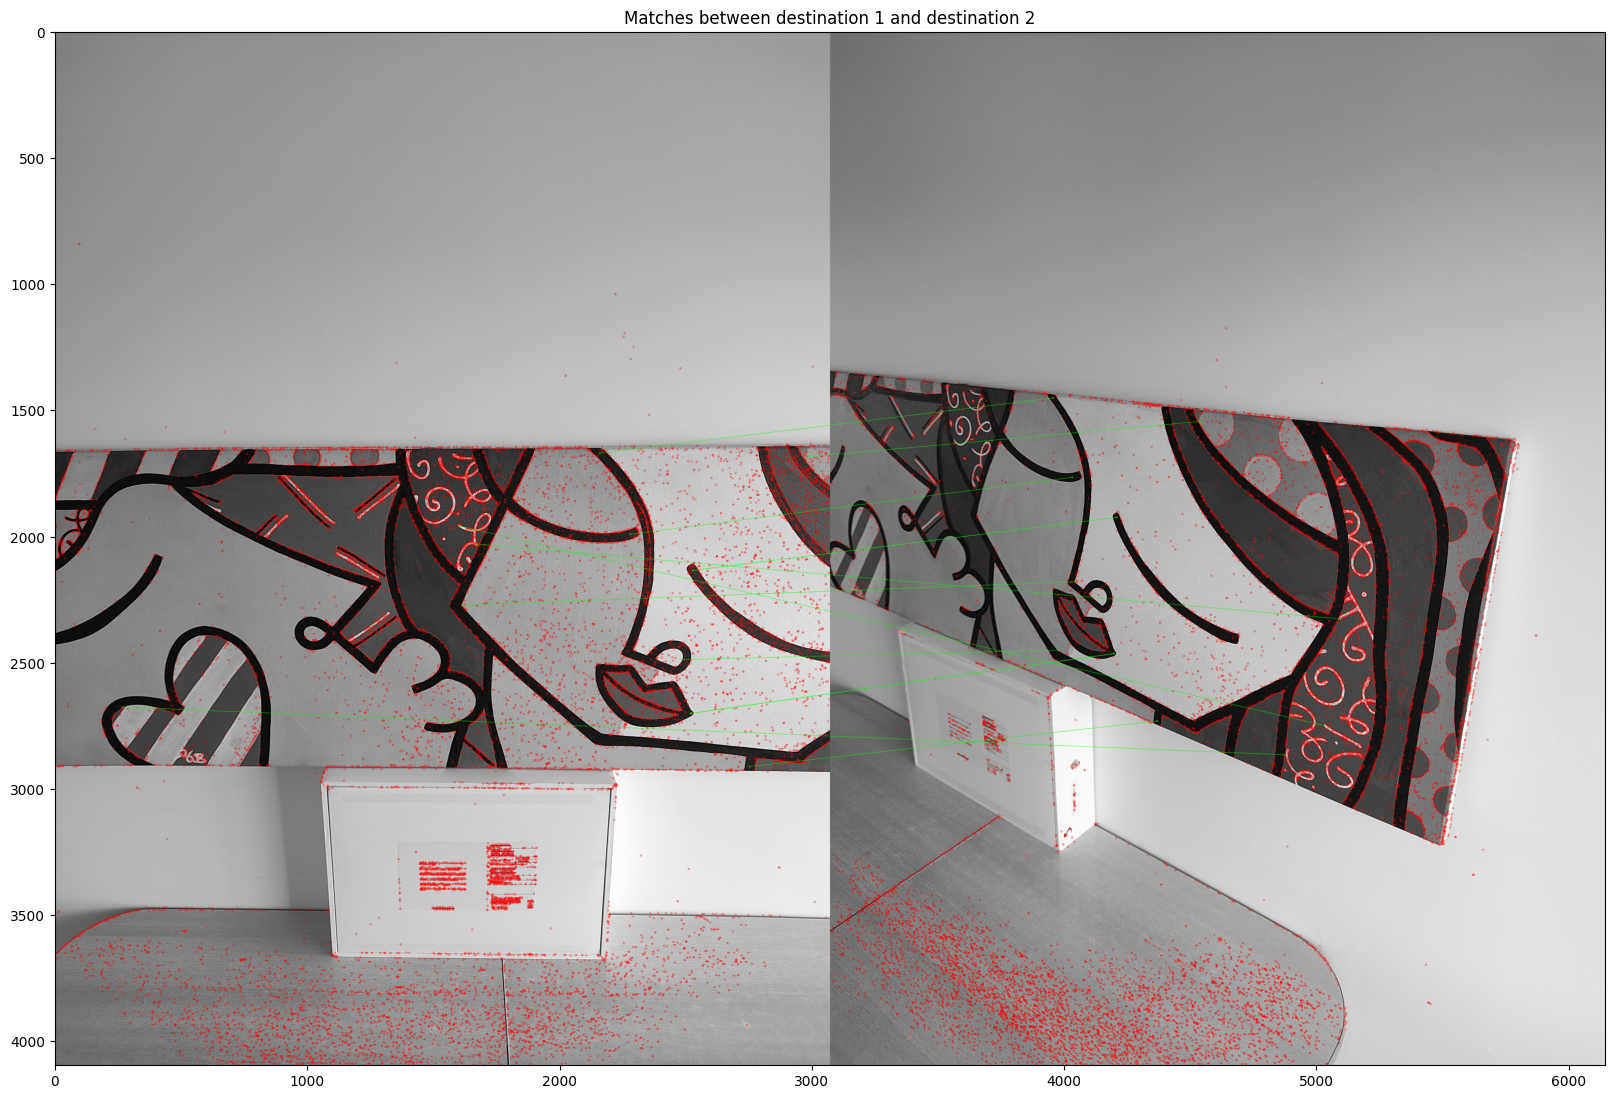

In [25]:
# Draw only good matches
draw_params_01 = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask01,
                   flags=cv2.DrawMatchesFlags_DEFAULT)
draw_params_12 = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask12,
                   flags=cv2.DrawMatchesFlags_DEFAULT)

img_matches01 = cv2.drawMatchesKnn(cuadro0, kp0, cuadro1, kp1, matches01, None, **draw_params_01)
img_matches12 = cv2.drawMatchesKnn(cuadro1, kp1, cuadro2, kp2, matches12, None, **draw_params_12)

plt.figure(figsize=(20, 16))
plt.imshow(img_matches01)
plt.title("Matches between source and destination 1")
plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(img_matches12)
plt.title("Matches between destination 1 and destination 2")
plt.show()

In [26]:
# Now we want to find the homography matrix that maps the source image to the destination image
good_matches01 = get_good_matches(matches01, matchesMask01)
good_matches12 = get_good_matches(matches12, matchesMask12)

print('Number of good matches:', len(good_matches01)) # remember: minimum matches needed to find the homography matrix is 4 (each match provides 2 equations)
print('Number of good matches:', len(good_matches12))

# Find homographies
H01, inliers01 = ransac_homography(kp0, kp1, good_matches01)
H12, inliers12 = ransac_homography(kp1, kp2, good_matches12)

print(f'Number of inliers: {len(inliers01)}')
print(f'Number of inliers: {len(inliers12)}')

Number of good matches: 51
Number of good matches: 14
Number of inliers: 31
Number of inliers: 8


In [27]:
# Warp images
result01 = warp_images(cuadro0, cuadro1, H01)
H21 = np.linalg.inv(H12)  
result21 = warp_images(cuadro2, cuadro1, H21)


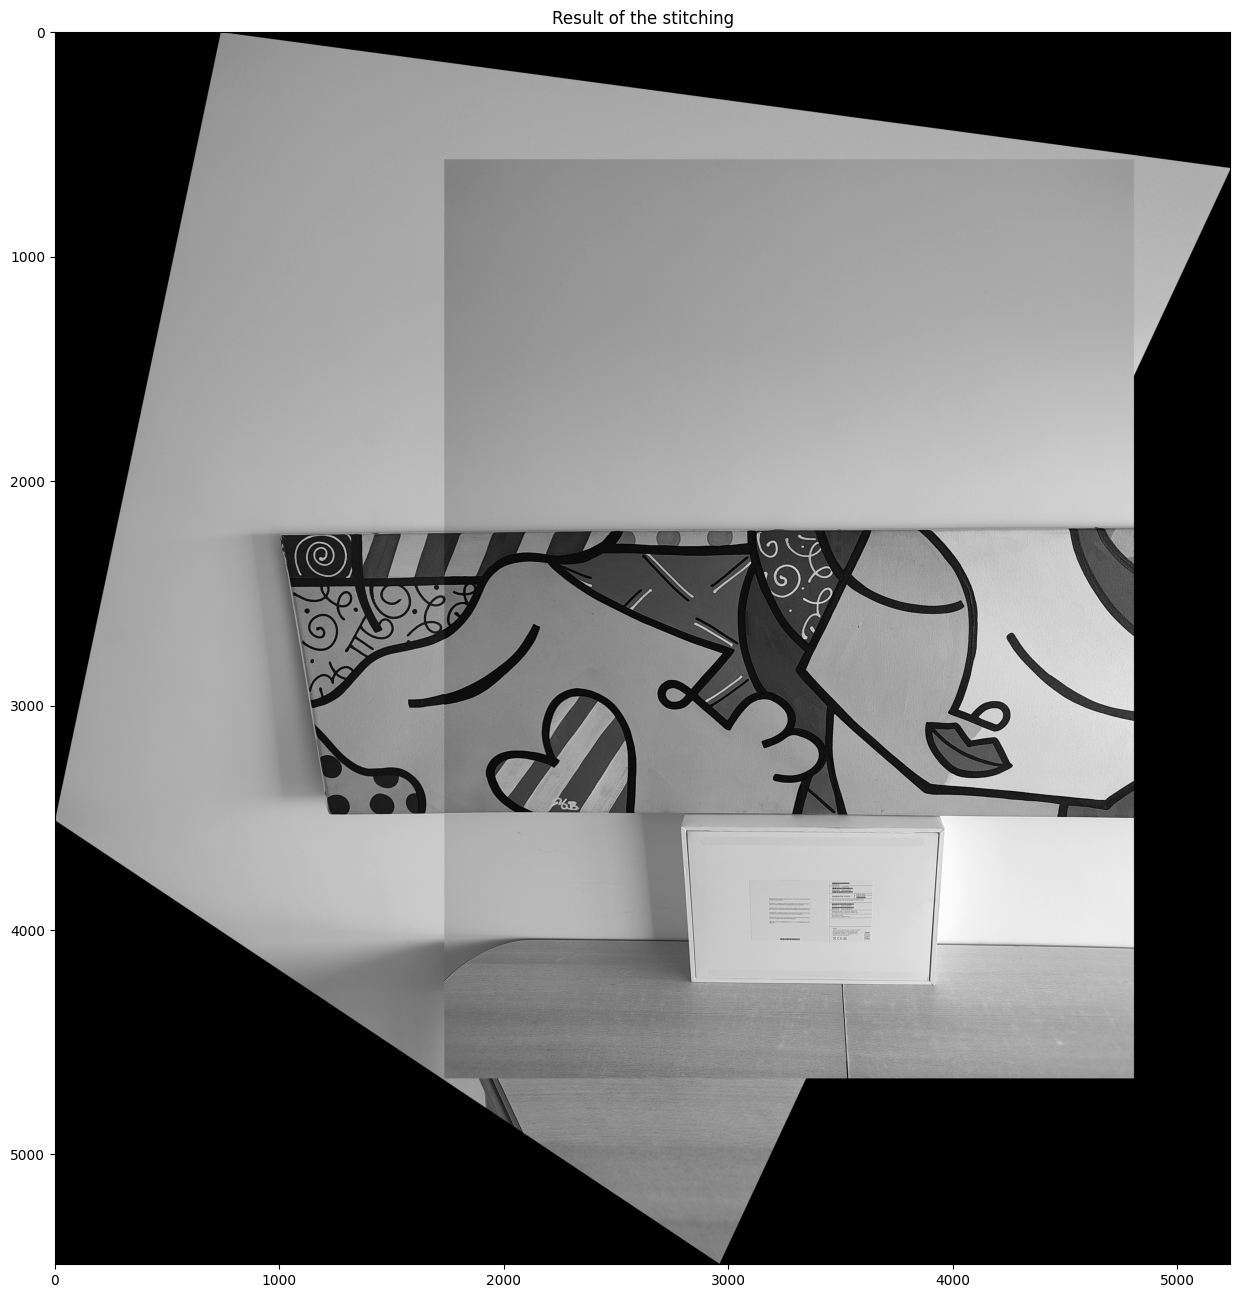

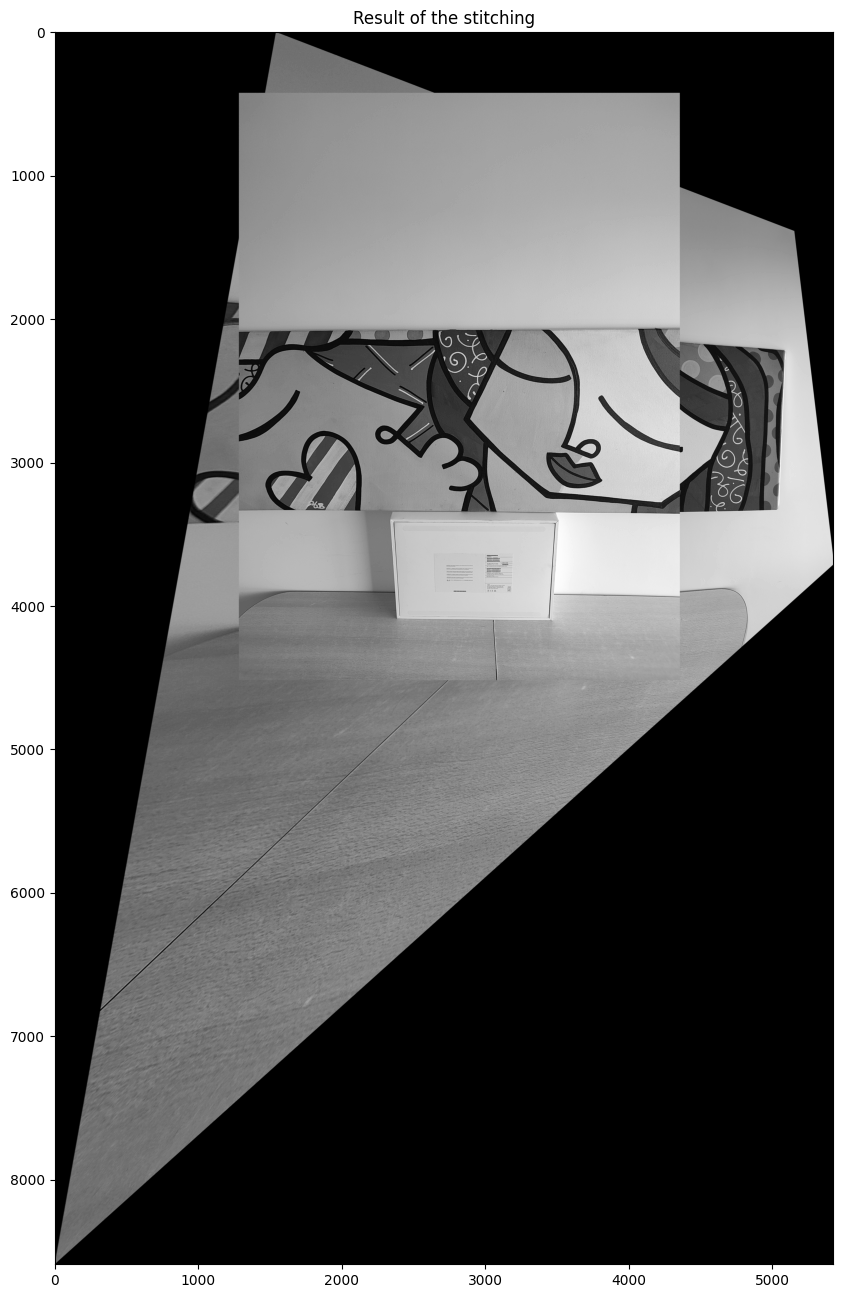

In [28]:
# Display result 
plt.figure(figsize=(20, 16))
plt.imshow(result01, cmap='gray')
plt.title("Result of the stitching")
plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(result21, cmap='gray')
plt.title("Result of the stitching")
plt.show()

In [29]:
kp01, des01 = algo.detectAndCompute(result01, None)
kp21, des21 = algo.detectAndCompute(result21, None)

matches, matchesMask = match_descriptors(des01, des21)

good_matches = get_good_matches(matches, matchesMask)
print('Number of good matches:', len(good_matches)) 

H, inliers = ransac_homography(kp01, kp21, good_matches)
print(f'Number of inliers: {len(inliers)}')
result = warp_images(result01, result21, H)

Number of good matches: 14986


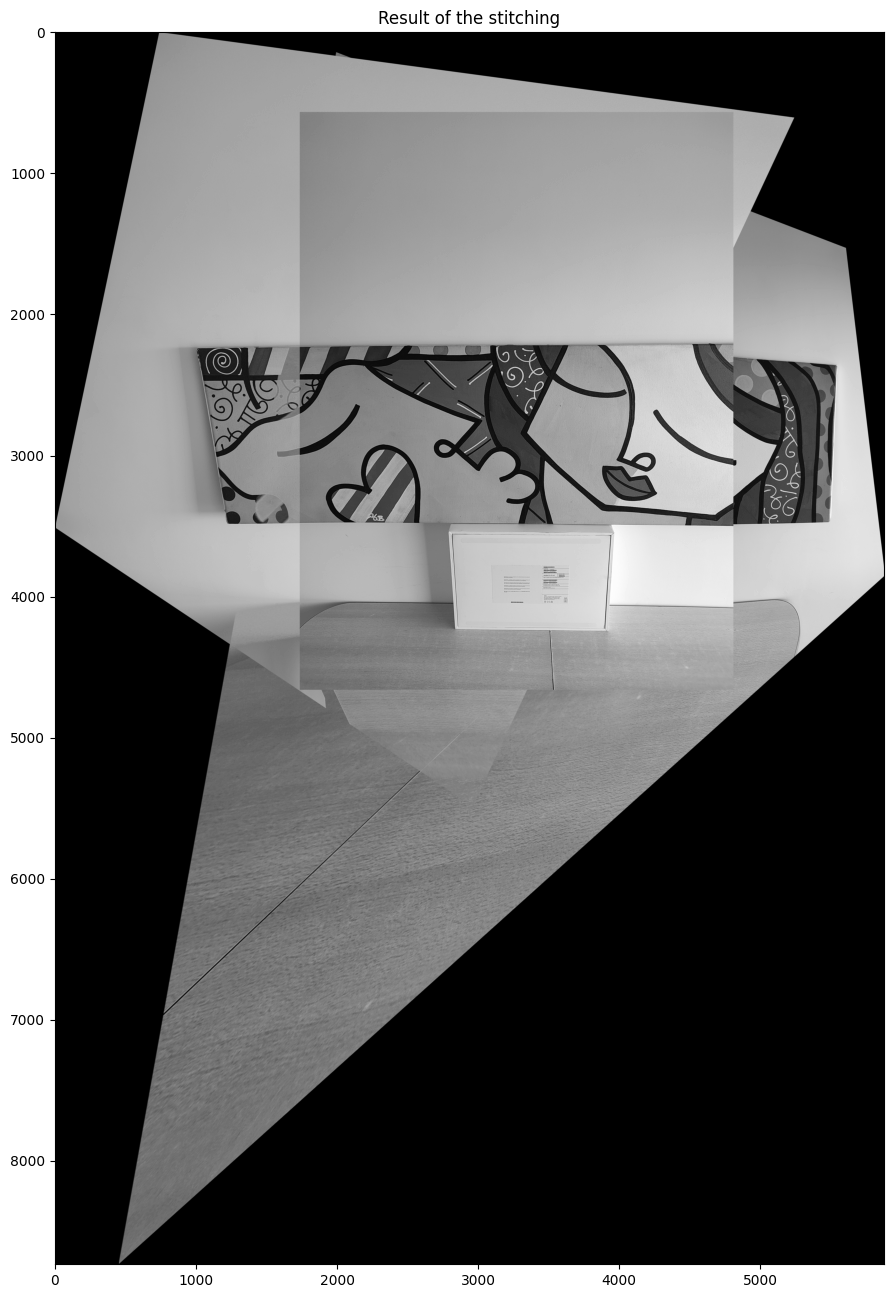

In [32]:
plt.figure(figsize=(20, 16))
plt.imshow(result, cmap='gray')
plt.title("Result of the stitching")
plt.show()